# Income Estimation model

# Pre-processing steps



### Income Estimation Model – Preprocessing Steps 

To prepare the data for a Random Forest model, I followed these steps:

1. **Descriptive Stats**  
   Took a quick look at the data — checked distributions, spotted weird stuff, and got a feel for what I was working with.

2. **Feature Engineering**  
   Built some new features using mean and max values:  
   - `payment_period` grouped by binned age ➡️ `payment_period_mean_by_bin_age`, `payment_period_max_by_bin_age`  
   - `amount` by `txn_description` ➡️ `amount_mean_by_txn_description`, `amount_max_by_txn_description`  
   - `balance` by `merchant_suburb` ➡️ `balance_mean_by_merchant_suburb`, `balance_max_by_merchant_suburb`

3. **High Cardinality Cleanup**  
   Dropped categorical columns with 10+ unique values — too noisy, not worth it.

4. **Handling Missing Values**  
   Filled missing data using the mode (most common value). Simple and effective!

5. **Categorical to Numeric**  
   Used `get_dummies()` to convert categorical features into numeric ones — ensuring compatibility with machine learning algorithms.


In [233]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy import stats
from sklearn.metrics import precision_score, recall_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [235]:
data=pd.read_excel(r'income_est.xlsx')
data

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,annual_salary
0,ACC-1598451071,26,16.25,35.39,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,81c48296-73be-44a7-befa-d053f48ce7cd,QLD,Ashmore,debit,authorized,a623070bfead4541a6b0fff8a09e706c,POS,20-30,2018,8,1,1,1,Wednesday,7,52856
1,ACC-1598451071,26,14.19,21.20,0.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,830a451c-316e-4a6a-bf25-e37caedca49e,NSW,Sydney,debit,authorized,13270a2a902145da9db4c951e04b51b9,SALES-POS,20-30,2018,8,1,1,13,Wednesday,7,52856
2,ACC-1598451071,26,3.25,17.95,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,b4e02c10-0852-4273-b8fd-7b3395e32eb0,QLD,Mermaid Beach,debit,authorized,329adf79878c4cf0aeb4188b4691c266,SALES-POS,20-30,2018,8,1,1,51,Wednesday,7,52856
3,ACC-1598451071,26,14.10,3.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,f2ef6270-cf91-409f-a6a2-fbd6735ea500,NSW,Byron Bay,debit,authorized,1c12c9ad77894ef8b507fb091e41e928,POS,20-30,2018,8,1,8,9,Wednesday,7,52856
4,ACC-1598451071,26,10.67,1006.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,44abc19c-aa5c-40bd-b1d0-9b2f236189ea,QLD,Bundall,debit,authorized,cd0113426970425a8524e55f4079408f,POS,20-30,2018,8,1,18,19,Wednesday,7,52856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,ACC-2153562714,24,3712.56,9707.77,NaN,CUS-423725039,2018-10-24,Linda,F,-31.88,116.00,0.0,NaN,NaN,NaN,credit,posted,fe1b1a6bdd9b43f7985acc4af7b0a101,PAY/SALARY,20-30,2018,10,24,14,0,Wednesday,30,45169
12039,ACC-1217063613,27,4863.62,4863.86,NaN,CUS-1739931018,2018-09-26,Kimberly,F,-37.82,147.61,0.0,NaN,NaN,NaN,credit,posted,8659baa692924427aefbf4077c5a9d67,PAY/SALARY,20-30,2018,9,26,13,0,Wednesday,30,59174
12040,ACC-1217063613,27,4863.62,8905.77,NaN,CUS-1739931018,2018-10-26,Kimberly,F,-37.82,147.61,0.0,NaN,NaN,NaN,credit,posted,e6d8f31d269d4e8388e115719a59dd98,PAY/SALARY,20-30,2018,10,26,13,0,Friday,30,59174
12041,ACC-3100725361,25,6107.23,6111.57,NaN,CUS-2178051368,2018-09-26,Ronald,M,-17.03,145.73,0.0,NaN,NaN,NaN,credit,posted,7eb1fdb7aefb40d1a8ada1d27f556542,PAY/SALARY,20-30,2018,9,26,15,0,Wednesday,30,74305


In [236]:
data.describe(include = 'all')

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,annual_salary
count,12043,12043.000000,12043.000000,12043.000000,7717.000000,12043,12043,12043,12043,12043.000000,12043.000000,883.0,7717,7717,7717,12043,12043,12043,12043,12043,12043.0,12043.000000,12043.000000,12043.000000,12043.000000,12043,12043.000000,12043.000000
unique,100,NaN,NaN,NaN,NaN,100,91,80,2,NaN,NaN,NaN,5725,8,1609,2,2,12043,6,7,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,ACC-1598451071,NaN,NaN,NaN,NaN,CUS-2487424745,2018-09-28,Michael,M,NaN,NaN,NaN,106e1272-44ab-4dcb-a438-dd98e0071e51,NSW,Melbourne,debit,authorized,a623070bfead4541a6b0fff8a09e706c,SALES-POS,20-30,NaN,NaN,NaN,NaN,NaN,Friday,NaN,NaN
freq,578,NaN,NaN,NaN,NaN,578,174,746,6285,NaN,NaN,NaN,14,2169,255,11160,7717,1,3934,5071,NaN,NaN,NaN,NaN,NaN,2073,NaN,NaN
mean,NaN,30.582330,187.933588,14704.195553,0.802644,NaN,NaN,NaN,NaN,-38.164347,143.648563,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,9.011957,15.862908,13.268621,19.009632,NaN,11.470315,68652.099311
std,NaN,10.046343,592.599934,31503.722652,0.398029,NaN,NaN,NaN,NaN,54.622791,16.669352,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.816511,8.899598,5.777284,19.879112,NaN,7.049721,24300.863348
min,NaN,18.000000,0.100000,0.240000,0.000000,NaN,NaN,NaN,NaN,-573.000000,114.620000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,8.000000,1.000000,0.000000,0.000000,NaN,0.000000,29875.000000
25%,NaN,22.000000,16.000000,3158.585000,1.000000,NaN,NaN,NaN,NaN,-37.700000,138.690000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,8.000000,8.000000,9.000000,0.000000,NaN,7.000000,51650.000000
50%,NaN,28.000000,29.000000,6432.010000,1.000000,NaN,NaN,NaN,NaN,-33.890000,145.230000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,9.000000,16.000000,13.000000,13.000000,NaN,14.000000,60494.000000
75%,NaN,38.000000,53.655000,12465.945000,1.000000,NaN,NaN,NaN,NaN,-30.750000,151.220000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,10.000000,24.000000,18.000000,36.000000,NaN,14.000000,81701.000000


In [237]:
data.columns

Index(['account', 'age', 'amount', 'balance', 'card_present_flag',
       'customer_id', 'date', 'first_name', 'gender', 'latitude', 'longitude',
       'merchant_code', 'merchant_id', 'merchant_state', 'merchant_suburb',
       'movement', 'status', 'transaction_id', 'txn_description', 'bin_age',
       'year', 'month', 'day', 'hour', 'minute', 'dow', 'payment_period',
       'annual_salary'],
      dtype='object')

In [238]:
statistics = ['mean','max']

In [239]:
data.columns

Index(['account', 'age', 'amount', 'balance', 'card_present_flag',
       'customer_id', 'date', 'first_name', 'gender', 'latitude', 'longitude',
       'merchant_code', 'merchant_id', 'merchant_state', 'merchant_suburb',
       'movement', 'status', 'transaction_id', 'txn_description', 'bin_age',
       'year', 'month', 'day', 'hour', 'minute', 'dow', 'payment_period',
       'annual_salary'],
      dtype='object')

In [240]:
for i in statistics:
    result = data.groupby(['bin_age']).agg({'payment_period': [i]})
    result.columns = [f'payment_period_{i}_by_bin_age']
    result.reset_index(inplace=True)

    data = pd.merge(data, result, on='bin_age', how='left')

data

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,annual_salary,payment_period_mean_by_bin_age,payment_period_max_by_bin_age
0,ACC-1598451071,26,16.25,35.39,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,81c48296-73be-44a7-befa-d053f48ce7cd,QLD,Ashmore,debit,authorized,a623070bfead4541a6b0fff8a09e706c,POS,20-30,2018,8,1,1,1,Wednesday,7,52856,13.650562,61
1,ACC-1598451071,26,14.19,21.20,0.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,830a451c-316e-4a6a-bf25-e37caedca49e,NSW,Sydney,debit,authorized,13270a2a902145da9db4c951e04b51b9,SALES-POS,20-30,2018,8,1,1,13,Wednesday,7,52856,13.650562,61
2,ACC-1598451071,26,3.25,17.95,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,b4e02c10-0852-4273-b8fd-7b3395e32eb0,QLD,Mermaid Beach,debit,authorized,329adf79878c4cf0aeb4188b4691c266,SALES-POS,20-30,2018,8,1,1,51,Wednesday,7,52856,13.650562,61
3,ACC-1598451071,26,14.10,3.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,f2ef6270-cf91-409f-a6a2-fbd6735ea500,NSW,Byron Bay,debit,authorized,1c12c9ad77894ef8b507fb091e41e928,POS,20-30,2018,8,1,8,9,Wednesday,7,52856,13.650562,61
4,ACC-1598451071,26,10.67,1006.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,44abc19c-aa5c-40bd-b1d0-9b2f236189ea,QLD,Bundall,debit,authorized,cd0113426970425a8524e55f4079408f,POS,20-30,2018,8,1,18,19,Wednesday,7,52856,13.650562,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,ACC-2153562714,24,3712.56,9707.77,NaN,CUS-423725039,2018-10-24,Linda,F,-31.88,116.00,0.0,NaN,NaN,NaN,credit,posted,fe1b1a6bdd9b43f7985acc4af7b0a101,PAY/SALARY,20-30,2018,10,24,14,0,Wednesday,30,45169,13.650562,61
12039,ACC-1217063613,27,4863.62,4863.86,NaN,CUS-1739931018,2018-09-26,Kimberly,F,-37.82,147.61,0.0,NaN,NaN,NaN,credit,posted,8659baa692924427aefbf4077c5a9d67,PAY/SALARY,20-30,2018,9,26,13,0,Wednesday,30,59174,13.650562,61
12040,ACC-1217063613,27,4863.62,8905.77,NaN,CUS-1739931018,2018-10-26,Kimberly,F,-37.82,147.61,0.0,NaN,NaN,NaN,credit,posted,e6d8f31d269d4e8388e115719a59dd98,PAY/SALARY,20-30,2018,10,26,13,0,Friday,30,59174,13.650562,61
12041,ACC-3100725361,25,6107.23,6111.57,NaN,CUS-2178051368,2018-09-26,Ronald,M,-17.03,145.73,0.0,NaN,NaN,NaN,credit,posted,7eb1fdb7aefb40d1a8ada1d27f556542,PAY/SALARY,20-30,2018,9,26,15,0,Wednesday,30,74305,13.650562,61


In [241]:
for i in statistics:
    result = data.groupby(['txn_description']).agg({'amount': [i]})
    result.columns = [f'amount_{i}_by_txn_description']
    result.reset_index(inplace=True)

    data = pd.merge(data, result, on='txn_description', how='left')

data

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,annual_salary,payment_period_mean_by_bin_age,payment_period_max_by_bin_age,amount_mean_by_txn_description,amount_max_by_txn_description
0,ACC-1598451071,26,16.25,35.39,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,81c48296-73be-44a7-befa-d053f48ce7cd,QLD,Ashmore,debit,authorized,a623070bfead4541a6b0fff8a09e706c,POS,20-30,2018,8,1,1,1,Wednesday,7,52856,13.650562,61,40.407412,7081.09
1,ACC-1598451071,26,14.19,21.20,0.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,830a451c-316e-4a6a-bf25-e37caedca49e,NSW,Sydney,debit,authorized,13270a2a902145da9db4c951e04b51b9,SALES-POS,20-30,2018,8,1,1,13,Wednesday,7,52856,13.650562,61,39.909789,4233.00
2,ACC-1598451071,26,3.25,17.95,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,b4e02c10-0852-4273-b8fd-7b3395e32eb0,QLD,Mermaid Beach,debit,authorized,329adf79878c4cf0aeb4188b4691c266,SALES-POS,20-30,2018,8,1,1,51,Wednesday,7,52856,13.650562,61,39.909789,4233.00
3,ACC-1598451071,26,14.10,3.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,f2ef6270-cf91-409f-a6a2-fbd6735ea500,NSW,Byron Bay,debit,authorized,1c12c9ad77894ef8b507fb091e41e928,POS,20-30,2018,8,1,8,9,Wednesday,7,52856,13.650562,61,40.407412,7081.09
4,ACC-1598451071,26,10.67,1006.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,44abc19c-aa5c-40bd-b1d0-9b2f236189ea,QLD,Bundall,debit,authorized,cd0113426970425a8524e55f4079408f,POS,20-30,2018,8,1,18,19,Wednesday,7,52856,13.650562,61,40.407412,7081.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,ACC-2153562714,24,3712.56,9707.77,NaN,CUS-423725039,2018-10-24,Linda,F,-31.88,116.00,0.0,NaN,NaN,NaN,credit,posted,fe1b1a6bdd9b43f7985acc4af7b0a101,PAY/SALARY,20-30,2018,10,24,14,0,Wednesday,30,45169,13.650562,61,1898.728029,8835.98
12039,ACC-1217063613,27,4863.62,4863.86,NaN,CUS-1739931018,2018-09-26,Kimberly,F,-37.82,147.61,0.0,NaN,NaN,NaN,credit,posted,8659baa692924427aefbf4077c5a9d67,PAY/SALARY,20-30,2018,9,26,13,0,Wednesday,30,59174,13.650562,61,1898.728029,8835.98
12040,ACC-1217063613,27,4863.62,8905.77,NaN,CUS-1739931018,2018-10-26,Kimberly,F,-37.82,147.61,0.0,NaN,NaN,NaN,credit,posted,e6d8f31d269d4e8388e115719a59dd98,PAY/SALARY,20-30,2018,10,26,13,0,Friday,30,59174,13.650562,61,1898.728029,8835.98
12041,ACC-3100725361,25,6107.23,6111.57,NaN,CUS-2178051368,2018-09-26,Ronald,M,-17.03,145.73,0.0,NaN,NaN,NaN,credit,posted,7eb1fdb7aefb40d1a8ada1d27f556542,PAY/SALARY,20-30,2018,9,26,15,0,Wednesday,30,74305,13.650562,61,1898.728029,8835.98


In [242]:
for i in statistics:
    result = data.groupby(['merchant_suburb']).agg({'balance': [i]})
    result.columns = [f'balance_{i}_by_merchant_suburb']
    result.reset_index(inplace=True)

    data = pd.merge(data, result, on='merchant_suburb', how='left')

data

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,annual_salary,payment_period_mean_by_bin_age,payment_period_max_by_bin_age,amount_mean_by_txn_description,amount_max_by_txn_description,balance_mean_by_merchant_suburb,balance_max_by_merchant_suburb
0,ACC-1598451071,26,16.25,35.39,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,81c48296-73be-44a7-befa-d053f48ce7cd,QLD,Ashmore,debit,authorized,a623070bfead4541a6b0fff8a09e706c,POS,20-30,2018,8,1,1,1,Wednesday,7,52856,13.650562,61,40.407412,7081.09,5340.941250,22315.43
1,ACC-1598451071,26,14.19,21.20,0.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,830a451c-316e-4a6a-bf25-e37caedca49e,NSW,Sydney,debit,authorized,13270a2a902145da9db4c951e04b51b9,SALES-POS,20-30,2018,8,1,1,13,Wednesday,7,52856,13.650562,61,39.909789,4233.00,10934.540901,205177.72
2,ACC-1598451071,26,3.25,17.95,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,b4e02c10-0852-4273-b8fd-7b3395e32eb0,QLD,Mermaid Beach,debit,authorized,329adf79878c4cf0aeb4188b4691c266,SALES-POS,20-30,2018,8,1,1,51,Wednesday,7,52856,13.650562,61,39.909789,4233.00,2391.202000,6808.64
3,ACC-1598451071,26,14.10,3.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,f2ef6270-cf91-409f-a6a2-fbd6735ea500,NSW,Byron Bay,debit,authorized,1c12c9ad77894ef8b507fb091e41e928,POS,20-30,2018,8,1,8,9,Wednesday,7,52856,13.650562,61,40.407412,7081.09,595.520000,1085.52
4,ACC-1598451071,26,10.67,1006.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,153.41,NaN,44abc19c-aa5c-40bd-b1d0-9b2f236189ea,QLD,Bundall,debit,authorized,cd0113426970425a8524e55f4079408f,POS,20-30,2018,8,1,18,19,Wednesday,7,52856,13.650562,61,40.407412,7081.09,2117.856000,4632.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,ACC-2153562714,24,3712.56,9707.77,NaN,CUS-423725039,2018-10-24,Linda,F,-31.88,116.00,0.0,NaN,NaN,NaN,credit,posted,fe1b1a6bdd9b43f7985acc4af7b0a101,PAY/SALARY,20-30,2018,10,24,14,0,Wednesday,30,45169,13.650562,61,1898.728029,8835.98,NaN,NaN
12039,ACC-1217063613,27,4863.62,4863.86,NaN,CUS-1739931018,2018-09-26,Kimberly,F,-37.82,147.61,0.0,NaN,NaN,NaN,credit,posted,8659baa692924427aefbf4077c5a9d67,PAY/SALARY,20-30,2018,9,26,13,0,Wednesday,30,59174,13.650562,61,1898.728029,8835.98,NaN,NaN
12040,ACC-1217063613,27,4863.62,8905.77,NaN,CUS-1739931018,2018-10-26,Kimberly,F,-37.82,147.61,0.0,NaN,NaN,NaN,credit,posted,e6d8f31d269d4e8388e115719a59dd98,PAY/SALARY,20-30,2018,10,26,13,0,Friday,30,59174,13.650562,61,1898.728029,8835.98,NaN,NaN
12041,ACC-3100725361,25,6107.23,6111.57,NaN,CUS-2178051368,2018-09-26,Ronald,M,-17.03,145.73,0.0,NaN,NaN,NaN,credit,posted,7eb1fdb7aefb40d1a8ada1d27f556542,PAY/SALARY,20-30,2018,9,26,15,0,Wednesday,30,74305,13.650562,61,1898.728029,8835.98,NaN,NaN


In [243]:
for i in data.columns:
    if data[i].dtype == 'object':
        data[i].fillna(value=data[i].mode()[0],inplace = True)
    if data[i].dtype!= 'object':
        data[i].fillna(value=data[i].mode()[0],inplace = True)


C:\Users\NIcat\AppData\Local\Temp\ipykernel_7648\1007763031.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(value=data[i].mode()[0],inplace = True)
C:\Users\NIcat\AppData\Local\Temp\ipykernel_7648\1007763031.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [245]:
data.describe(include = 'all')

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,annual_salary,payment_period_mean_by_bin_age,payment_period_max_by_bin_age,amount_mean_by_txn_description,amount_max_by_txn_description,balance_mean_by_merchant_suburb,balance_max_by_merchant_suburb
count,12043,12043.000000,12043.000000,12043.000000,12043.000000,12043,12043,12043,12043,12043.000000,12043.000000,12043.0,12043,12043,12043,12043,12043,12043,12043,12043,12043.0,12043.000000,12043.000000,12043.000000,12043.000000,12043,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000
unique,100,NaN,NaN,NaN,NaN,100,91,80,2,NaN,NaN,NaN,5725,8,1609,2,2,12043,6,7,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ACC-1598451071,NaN,NaN,NaN,NaN,CUS-2487424745,2018-09-28,Michael,M,NaN,NaN,NaN,106e1272-44ab-4dcb-a438-dd98e0071e51,NSW,Melbourne,debit,authorized,a623070bfead4541a6b0fff8a09e706c,SALES-POS,20-30,NaN,NaN,NaN,NaN,NaN,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,578,NaN,NaN,NaN,NaN,578,174,746,6285,NaN,NaN,NaN,4340,6495,4581,11160,7717,1,3934,5071,NaN,NaN,NaN,NaN,NaN,2073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,30.582330,187.933588,14704.195553,0.873536,NaN,NaN,NaN,NaN,-38.164347,143.648563,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,9.011957,15.862908,13.268621,19.009632,NaN,11.470315,68652.099311,11.470315,33.660301,187.933588,4819.233066,12572.283780,133853.737951
std,NaN,10.046343,592.599934,31503.722652,0.332385,NaN,NaN,NaN,NaN,54.622791,16.669352,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.816511,8.899598,5.777284,19.879112,NaN,7.049721,24300.863348,2.033555,23.336297,481.585450,2284.221028,11316.251789,117790.676548
min,NaN,18.000000,0.100000,0.240000,0.000000,NaN,NaN,NaN,NaN,-573.000000,114.620000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,8.000000,1.000000,0.000000,0.000000,NaN,0.000000,29875.000000,7.000000,7.000000,39.909789,1916.000000,6.480000,6.480000
25%,NaN,22.000000,16.000000,3158.585000,1.000000,NaN,NaN,NaN,NaN,-37.700000,138.690000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,8.000000,8.000000,9.000000,0.000000,NaN,7.000000,51650.000000,9.047577,14.000000,39.909789,1981.000000,7039.283571,16243.750000
50%,NaN,28.000000,29.000000,6432.010000,1.000000,NaN,NaN,NaN,NaN,-33.890000,145.230000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,9.000000,16.000000,13.000000,13.000000,NaN,14.000000,60494.000000,11.276875,14.000000,40.407412,4233.000000,13823.178431,63489.520000
75%,NaN,38.000000,53.655000,12465.945000,1.000000,NaN,NaN,NaN,NaN,-30.750000,151.220000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0,10.000000,24.000000,18.000000,36.000000,NaN,14.000000,81701.000000,13.650562,61.000000,77.613077,7081.090000,13823.178431,266981.300000


In [246]:
data.columns

Index(['account', 'age', 'amount', 'balance', 'card_present_flag',
       'customer_id', 'date', 'first_name', 'gender', 'latitude', 'longitude',
       'merchant_code', 'merchant_id', 'merchant_state', 'merchant_suburb',
       'movement', 'status', 'transaction_id', 'txn_description', 'bin_age',
       'year', 'month', 'day', 'hour', 'minute', 'dow', 'payment_period',
       'annual_salary', 'payment_period_mean_by_bin_age',
       'payment_period_max_by_bin_age', 'amount_mean_by_txn_description',
       'amount_max_by_txn_description', 'balance_mean_by_merchant_suburb',
       'balance_max_by_merchant_suburb'],
      dtype='object')

In [247]:
data.drop(['account', 'customer_id', 'date', 'first_name', 'merchant_id', 'merchant_suburb', 'transaction_id'],  axis=1,inplace=True)

In [248]:
data=pd.get_dummies(data,dtype = int)
data

,age,amount,balance,card_present_flag,latitude,longitude,merchant_code,year,month,day,hour,minute,payment_period,annual_salary,payment_period_mean_by_bin_age,payment_period_max_by_bin_age,amount_mean_by_txn_description,amount_max_by_txn_description,balance_mean_by_merchant_suburb,balance_max_by_merchant_suburb,gender_F,gender_M,merchant_state_ACT,merchant_state_NSW,merchant_state_NT,merchant_state_QLD,merchant_state_SA,merchant_state_TAS,merchant_state_VIC,merchant_state_WA,movement_credit,movement_debit,status_authorized,status_posted,txn_description_INTER BANK,txn_description_PAY/SALARY,txn_description_PAYMENT,txn_description_PHONE BANK,txn_description_POS,txn_description_SALES-POS,bin_age_20-30,bin_age_30-40,bin_age_40-50,bin_age_50-60,bin_age_60-70,bin_age_70>,bin_age_<20,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,26,16.25,35.39,1.0,-27.95,153.41,0.0,2018,8,1,1,1,7,52856,13.650562,61,40.407412,7081.09,5340.941250,22315.43,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,26,14.19,21.20,0.0,-27.95,153.41,0.0,2018,8,1,1,13,7,52856,13.650562,61,39.909789,4233.00,10934.540901,205177.72,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,26,3.25,17.95,1.0,-27.95,153.41,0.0,2018,8,1,1,51,7,52856,13.650562,61,39.909789,4233.00,2391.202000,6808.64,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,26,14.10,3.85,1.0,-27.95,153.41,0.0,2018,8,1,8,9,7,52856,13.650562,61,40.407412,7081.09,595.520000,1085.52,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,26,10.67,1006.85,1.0,-27.95,153.41,0.0,2018,8,1,18,19,7,52856,13.650562,61,40.407412,7081.09,2117.856000,4632.05,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,24,3712.56,9707.77,1.0,-31.88,116.00,0.0,2018,10,24,14,0,30,45169,13.650562,61,1898.728029,8835.98,13823.178431,266981.30,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
12039,27,4863.62,4863.86,1.0,-37.82,147.61,0.0,2018,9,26,13,0,30,59174,13.650562,61,1898.728029,8835.98,13823.178431,266981.30,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
12040,27,4863.62,8905.77,1.0,-37.82,147.61,0.0,2018,10,26,13,0,30,59174,13.650562,61,1898.728029,8835.98,13823.178431,266981.30,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
12041,25,6107.23,6111.57,1.0,-17.03,145.73,0.0,2018,9,26,15,0,30,74305,13.650562,61,1898.728029,8835.98,13823.178431,266981.30,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [249]:
data.isnull().sum()

age                                0
amount                             0
balance                            0
card_present_flag                  0
latitude                           0
longitude                          0
merchant_code                      0
year                               0
month                              0
day                                0
hour                               0
minute                             0
payment_period                     0
annual_salary                      0
payment_period_mean_by_bin_age     0
payment_period_max_by_bin_age      0
amount_mean_by_txn_description     0
amount_max_by_txn_description      0
balance_mean_by_merchant_suburb    0
balance_max_by_merchant_suburb     0
gender_F                           0
gender_M                           0
merchant_state_ACT                 0
merchant_state_NSW                 0
merchant_state_NT                  0
merchant_state_QLD                 0
merchant_state_SA                  0
m

# Modeling Steps 

I built three versions of the model:

Default model – just using the default parameters

Feature importance–based model – built using all features, but paying attention to their importance

Optimized model – built using only the most relevant features and tuned parameters

For each version, I evaluated the model using Train and Test R² scores to compare performance 

 For the optimized model, I only included features with importance > 1%, and then fine-tuned the parameters to get the best performance.

In [252]:
data.columns

Index(['age', 'amount', 'balance', 'card_present_flag', 'latitude',
       'longitude', 'merchant_code', 'year', 'month', 'day', 'hour', 'minute',
       'payment_period', 'annual_salary', 'payment_period_mean_by_bin_age',
       'payment_period_max_by_bin_age', 'amount_mean_by_txn_description',
       'amount_max_by_txn_description', 'balance_mean_by_merchant_suburb',
       'balance_max_by_merchant_suburb', 'gender_F', 'gender_M',
       'merchant_state_ACT', 'merchant_state_NSW', 'merchant_state_NT',
       'merchant_state_QLD', 'merchant_state_SA', 'merchant_state_TAS',
       'merchant_state_VIC', 'merchant_state_WA', 'movement_credit',
       'movement_debit', 'status_authorized', 'status_posted',
       'txn_description_INTER BANK', 'txn_description_PAY/SALARY',
       'txn_description_PAYMENT', 'txn_description_PHONE BANK',
       'txn_description_POS', 'txn_description_SALES-POS', 'bin_age_20-30',
       'bin_age_30-40', 'bin_age_40-50', 'bin_age_50-60', 'bin_age_60-70',
     

In [253]:
x=data.drop(['annual_salary'],axis=1)
y=data['annual_salary']

In [278]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

In [280]:
def evaluate(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    mae_test = metrics.mean_absolute_error(y_test, y_pred)
    mse_test = metrics.mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = metrics.r2_score(y_test, y_pred)


    y_pred_train = model.predict(X_train)

    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    mse_train = metrics.mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)


    results_dict = {
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
        'Train': [mae_train, mse_train, rmse_train, r2_train*100],
        'Test': [mae_test, mse_test, rmse_test, r2_test*100]
    }

    results_df = pd.DataFrame(results_dict)
    
    return results_df

In [282]:
reg = DecisionTreeRegressor(random_state=42)

reg.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [287]:
evaluate(reg, X_train, y_train, X_test, y_test)

,Metric,Train,Test
0,MAE,0.0,2.187077e+02
1,MSE,0.0,9.499593e+06
2,RMSE,0.0,3.082141e+03
3,R2,100.0,9.837794e+01


In [293]:
regRF = RandomForestRegressor(random_state=42)

regRF.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [295]:
evaluate(regRF, X_train, y_train, X_test, y_test)

,Metric,Train,Test
0,MAE,239.901613,6.035307e+02
1,MSE,871222.066918,4.729248e+06
2,RMSE,933.392772,2.174684e+03
3,R2,99.852963,9.919248e+01


In [297]:
def plot_feature_importances(model, feature_names):
    
    importances = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by="Importance", ascending=False)
   
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title("Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis() 
    plt.show()
    
    return importance_df

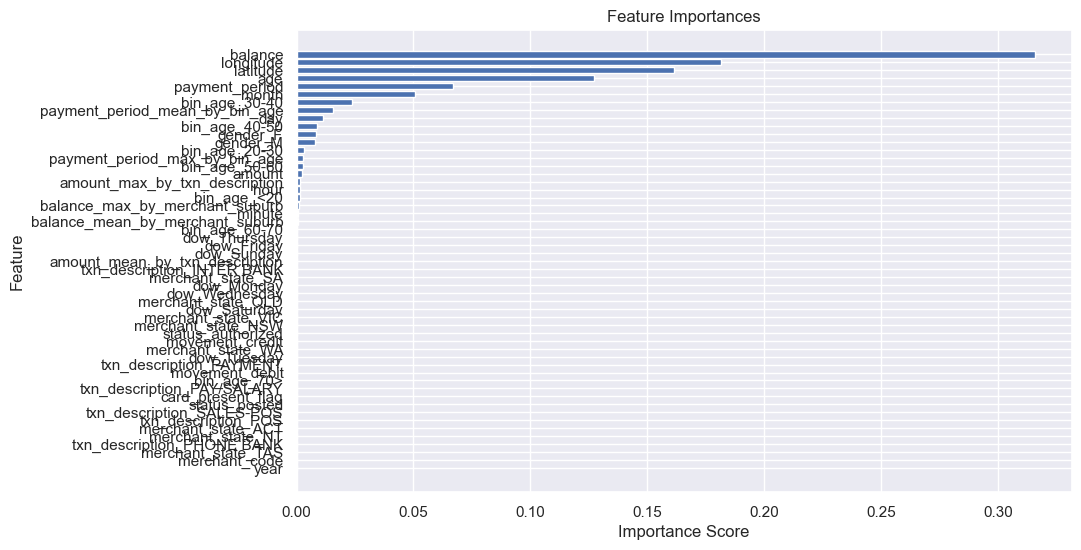

,Feature,Importance
2,balance,0.315516
5,longitude,0.181290
4,latitude,0.161397
0,age,0.127069
12,payment_period,0.067006
8,month,0.050550
40,bin_age_30-40,0.023785
13,payment_period_mean_by_bin_age,0.015399
9,day,0.011317
41,bin_age_40-50,0.008843


In [299]:
feature_names = X_train.columns

feature_importance_df = plot_feature_importances(regRF, feature_names)

feature_importance_df

In [305]:
X_train.columns

Index(['age', 'amount', 'balance', 'card_present_flag', 'latitude',
       'longitude', 'merchant_code', 'year', 'month', 'day', 'hour', 'minute',
       'payment_period', 'payment_period_mean_by_bin_age',
       'payment_period_max_by_bin_age', 'amount_mean_by_txn_description',
       'amount_max_by_txn_description', 'balance_mean_by_merchant_suburb',
       'balance_max_by_merchant_suburb', 'gender_F', 'gender_M',
       'merchant_state_ACT', 'merchant_state_NSW', 'merchant_state_NT',
       'merchant_state_QLD', 'merchant_state_SA', 'merchant_state_TAS',
       'merchant_state_VIC', 'merchant_state_WA', 'movement_credit',
       'movement_debit', 'status_authorized', 'status_posted',
       'txn_description_INTER BANK', 'txn_description_PAY/SALARY',
       'txn_description_PAYMENT', 'txn_description_PHONE BANK',
       'txn_description_POS', 'txn_description_SALES-POS', 'bin_age_20-30',
       'bin_age_30-40', 'bin_age_40-50', 'bin_age_50-60', 'bin_age_60-70',
       'bin_age_70>', 

In [307]:
regRF_selected = RandomForestRegressor(random_state=42)
regRF_selected.fit(X_train[['day','payment_period_mean_by_bin_age','bin_age_30-40','month','payment_period','age','latitude','longitude','balance']],y_train)

RandomForestRegressor(random_state=42)

In [309]:
evaluate(regRF_selected, X_train[['day','payment_period_mean_by_bin_age','bin_age_30-40','month','payment_period','age','latitude','longitude','balance']], y_train, 
         X_test[['day','payment_period_mean_by_bin_age','bin_age_30-40','month','payment_period','age','latitude','longitude','balance']], y_test)

,Metric,Train,Test
0,MAE,146.120861,3.655865e+02
1,MSE,542177.206076,3.093599e+06
2,RMSE,736.326834,1.758863e+03
3,R2,99.908496,9.947177e+01


In [313]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]

# Create the random grid
random_grid = {'n_estimators': n_estimators, # Number of trees in random forest
               'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
               'max_depth': max_depth, # Maximum number of levels in tree
               'min_samples_split': [20,50], # Minimum number of samples required to split a node
               'min_samples_leaf': [5, 8, 10]} # Minimum number of samples required at each leaf node

rf_random = RandomizedSearchCV(estimator = regRF_selected, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)

rf_random.fit(X_train[['day','payment_period_mean_by_bin_age','bin_age_30-40','month','payment_period','age','latitude','longitude','balance']], y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\NIcat\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
141 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\NIcat\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\NIcat\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\NIcat\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\NIcat\anaconda3\Lib\site-package

{'n_estimators': 377,
 'min_samples_split': 20,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 37}

In [315]:
optimized_model = rf_random.best_estimator_

evaluate(optimized_model, X_train[['day','payment_period_mean_by_bin_age','bin_age_30-40','month','payment_period','age','latitude','longitude','balance']], y_train,
         X_test[['day','payment_period_mean_by_bin_age','bin_age_30-40','month','payment_period','age','latitude','longitude','balance']], y_test)

,Metric,Train,Test
0,MAE,9.526427e+02,1.155454e+03
1,MSE,4.761840e+06,6.343224e+06
2,RMSE,2.182164e+03,2.518576e+03
3,R2,9.919634e+01,9.891689e+01


# Univariate Analysis 

I performed univariate R² analysis on the optimized model to see how much each feature contributes on its own.

 I kept only the features where:

The Test R² score was above 5%, and

The feature didn’t cause overfitting (i.e., the gap between train and test R² was reasonable)

This helped me focus on the most stable and meaningful predictors 

In [319]:
variables = []
train_r2_scores = []
test_r2_scores = []

for i in X_train[['day','payment_period_mean_by_bin_age','bin_age_30-40','month','payment_period','age','latitude','longitude','balance']].columns: 
    X_train_single_var = X_train[[i]]
    X_test_single_var = X_test[[i]]

    # Fit a regression model using the single variable on the training set
    optimized_model.fit(X_train_single_var, y_train)
    y_pred_train_single_var = optimized_model.predict(X_train_single_var)

    # Calculate R2 for the single variable model on the training set
    train_r2 = metrics.r2_score(y_train, y_pred_train_single_var)

    # Fit a regression model using the single variable on the test set
    y_pred_test_single_var = optimized_model.predict(X_test_single_var)

    # Calculate R2 for the single variable model on the test set
    test_r2 = metrics.r2_score(y_test, y_pred_test_single_var)

    # Append the results to the lists
    variables.append(i)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Create a DataFrame from the results

results_df = pd.DataFrame({'Variable': variables, 'Train R2': train_r2_scores, 'Test R2': test_r2_scores})

results_df_sorted = results_df.sort_values(by='Test R2', ascending=False)

pd.options.display.float_format = '{:.4f}'.format

results_df_sorted

,Variable,Train R2,Test R2
7,longitude,0.8124,0.8225
6,latitude,0.7885,0.7759
5,age,0.3575,0.3742
8,balance,0.4753,0.2434
1,payment_period_mean_by_bin_age,0.0782,0.0746
4,payment_period,0.0706,0.0685
2,bin_age_30-40,0.0594,0.0578
3,month,0.0002,-0.0011
0,day,0.0060,-0.0020


# Final Model 
For the final model, I used only the top-performing variables — the ones that had the biggest impact on model accuracy.

 This helped simplify the model while keeping performance strong and stable.

The result: a cleaner, more focused model that does the job without unnecessary complexity 



In [329]:
results_df_sorted.Variable.tolist()

['longitude',
 'latitude',
 'age',
 'balance',
 'payment_period_mean_by_bin_age',
 'payment_period',
 'bin_age_30-40',
 'month',
 'day']

In [331]:
inputs=data[['longitude',
 'latitude',
 'age',
 'balance',
 'payment_period_mean_by_bin_age',
 'payment_period',
 'bin_age_30-40']]

In [333]:
X_train, X_test, y_train, y_test = train_test_split(inputs, y, test_size=0.3, random_state=42)

In [335]:
opt = optimized_model.fit(X_train, y_train)

In [337]:
result = evaluate(opt, X_train, y_train, X_test, y_test)
result

,Metric,Train,Test
0,MAE,653.6842,801.1077
1,MSE,2827182.3474,4010682.6869
2,RMSE,1681.4227,2002.6689
3,R2,99.5229,99.3152


# Deployment 
Using the final model, I generated income predictions for the income_deploy dataset.

Everything was already preprocessed the same way, so I just applied the trained model and got the results ready for use 

The model is now ready to be integrated wherever needed — whether it's for reporting, dashboards, or further analysis 

In [389]:
df=pd.read_excel(r'income_deploy.xlsx')
df

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period
0,ACC-4258502723,24,116.2600,4241.7600,1.0000,CUS-3378712515,2018-10-08,Kimberly,F,-37.7400,145.4500,NaN,e7bf57d9-9eeb-41b4-886e-efb676a5bd80,QLD,Port Douglas,debit,authorized,b1e504ecf44840abb3a48b4ab8510f00,SALES-POS,20-30,2018,10,8,13,33,Monday,7
1,ACC-4258502723,24,14.1800,5122.4900,1.0000,CUS-3378712515,2018-10-11,Kimberly,F,-37.7400,145.4500,NaN,7770e116-8b4a-4d48-b0f5-7a6399958848,VIC,Melton,debit,authorized,dfa272cc57334c7ca87f61a258cb5b90,SALES-POS,20-30,2018,10,11,12,7,Thursday,7
2,ACC-1279356312,44,17.4000,5906.2800,1.0000,CUS-1892177589,2018-08-29,Tyler,M,-37.7300,144.7900,NaN,8bee9f57-4517-4f80-b7ee-c161f33421e2,VIC,Preston,debit,authorized,d87dc36be2a2414784dd1c84ced28c71,POS,40-50,2018,8,29,9,43,Wednesday,14
3,ACC-1344825761,46,22.0000,15729.7300,NaN,CUS-1499065773,2018-08-17,Sarah,F,-33.9100,151.0900,NaN,NaN,NaN,NaN,debit,posted,4d250222351c4fdb90f7a3085f881276,PAYMENT,40-50,2018,8,17,14,0,Friday,14
4,ACC-2171593283,19,33.0000,11168.8100,NaN,CUS-2317998716,2018-09-06,Fernando,M,-36.0400,146.9400,NaN,NaN,NaN,NaN,debit,posted,a4154a29a5d642ca9643b402a87e39d3,PAYMENT,<20,2018,9,6,5,0,Thursday,14
5,ACC-240804743,29,56.0000,7651.4600,NaN,CUS-261674136,2018-08-29,Kenneth,M,-30.7500,121.4800,NaN,NaN,NaN,NaN,debit,posted,010cfffccf6c4fefb0a7d0b88a6d68da,PAYMENT,20-30,2018,8,29,14,0,Wednesday,14
6,ACC-3954677887,47,24.0000,1161.9100,NaN,CUS-3716701010,2018-08-11,Ruth,F,-32.2800,115.7200,NaN,NaN,NaN,NaN,debit,posted,ec40f0d4f9be46f18d93bf86971f38dc,PAYMENT,40-50,2018,8,11,23,0,Saturday,7
7,ACC-2920611728,69,39.1200,5215.7700,1.0000,CUS-1388323263,2018-09-12,Tyler,M,-37.7600,144.9600,NaN,9cf12ed7-1600-403d-bb24-7f61d51609ef,VIC,Hoppers Crossing,debit,authorized,9c4b758fc15c4aaca329872b206da045,SALES-POS,60-70,2018,9,12,1,12,Wednesday,7
8,ACC-2305712452,18,18.0400,2390.8800,1.0000,CUS-1842679196,2018-08-31,Debra,F,-34.8900,138.6100,NaN,ae05bf40-b7dc-41a1-8ac1-61c0e8608760,SA,Gilles Plains,debit,authorized,03a5e32154914752a4316fa6663633b6,SALES-POS,<20,2018,8,31,21,19,Friday,7
9,ACC-1710017148,19,16.1800,1609.1600,1.0000,CUS-883482547,2018-08-01,Michelle,F,-34.0100,150.8200,NaN,499b1c74-d767-43d6-a084-b20d00010c70,NSW,Blacktown,debit,authorized,927d07bdbeb743ebab2865f86132cd99,POS,<20,2018,8,1,14,37,Wednesday,14


In [390]:
df.describe(include = 'all')


,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period
count,30,30.0000,30.0000,30.0000,16.0000,30,30,30,30,30.0000,30.0000,5.0000,16,16,16,30,30,30,30,30,30.0000,30.0000,30.0000,30.0000,30.0000,30,30.0000
unique,27,NaN,NaN,NaN,NaN,27,28,25,2,NaN,NaN,NaN,16,5,16,2,2,30,5,6,NaN,NaN,NaN,NaN,NaN,6,NaN
top,ACC-4258502723,NaN,NaN,NaN,NaN,CUS-3378712515,2018-10-08,Kimberly,M,NaN,NaN,NaN,e7bf57d9-9eeb-41b4-886e-efb676a5bd80,VIC,Port Douglas,debit,authorized,b1e504ecf44840abb3a48b4ab8510f00,SALES-POS,20-30,NaN,NaN,NaN,NaN,NaN,Wednesday,NaN
freq,2,NaN,NaN,NaN,NaN,2,2,2,16,NaN,NaN,NaN,1,7,1,25,16,1,8,12,NaN,NaN,NaN,NaN,NaN,9,NaN
mean,NaN,31.6000,280.7057,5160.8720,0.8750,NaN,NaN,NaN,NaN,-68.6817,149.3120,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0000,8.7333,16.2333,11.8000,10.3333,NaN,9.8000
std,NaN,12.4861,583.6299,3397.2654,0.3416,NaN,NaN,NaN,NaN,137.1997,31.2826,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.7849,9.0198,5.9908,14.3607,NaN,3.9427
min,NaN,18.0000,3.6700,134.7800,0.0000,NaN,NaN,NaN,NaN,-573.0000,115.7200,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0000,8.0000,1.0000,1.0000,0.0000,NaN,0.0000
25%,NaN,22.0000,22.5000,2400.6800,1.0000,NaN,NaN,NaN,NaN,-37.7375,140.2000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0000,8.0000,8.0000,9.2500,0.0000,NaN,7.0000
50%,NaN,26.5000,39.5150,4818.1300,1.0000,NaN,NaN,NaN,NaN,-33.9350,145.4500,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0000,9.0000,16.5000,13.0000,1.5000,NaN,7.0000
75%,NaN,40.0000,101.0000,7146.9850,1.0000,NaN,NaN,NaN,NaN,-31.9250,151.2100,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0000,9.0000,23.0000,14.0000,15.7500,NaN,14.0000


In [393]:
statistics = ['mean','max']

In [395]:
for i in statistics:
    result = df.groupby(['bin_age']).agg({'payment_period': [i]})
    result.columns = [f'payment_period_{i}_by_bin_age']
    result.reset_index(inplace=True)

    df = pd.merge(df, result, on='bin_age', how='left')

df

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,payment_period_mean_by_bin_age,payment_period_max_by_bin_age
0,ACC-4258502723,24,116.2600,4241.7600,1.0000,CUS-3378712515,2018-10-08,Kimberly,F,-37.7400,145.4500,NaN,e7bf57d9-9eeb-41b4-886e-efb676a5bd80,QLD,Port Douglas,debit,authorized,b1e504ecf44840abb3a48b4ab8510f00,SALES-POS,20-30,2018,10,8,13,33,Monday,7,10.5000,14
1,ACC-4258502723,24,14.1800,5122.4900,1.0000,CUS-3378712515,2018-10-11,Kimberly,F,-37.7400,145.4500,NaN,7770e116-8b4a-4d48-b0f5-7a6399958848,VIC,Melton,debit,authorized,dfa272cc57334c7ca87f61a258cb5b90,SALES-POS,20-30,2018,10,11,12,7,Thursday,7,10.5000,14
2,ACC-1279356312,44,17.4000,5906.2800,1.0000,CUS-1892177589,2018-08-29,Tyler,M,-37.7300,144.7900,NaN,8bee9f57-4517-4f80-b7ee-c161f33421e2,VIC,Preston,debit,authorized,d87dc36be2a2414784dd1c84ced28c71,POS,40-50,2018,8,29,9,43,Wednesday,14,9.8000,14
3,ACC-1344825761,46,22.0000,15729.7300,NaN,CUS-1499065773,2018-08-17,Sarah,F,-33.9100,151.0900,NaN,NaN,NaN,NaN,debit,posted,4d250222351c4fdb90f7a3085f881276,PAYMENT,40-50,2018,8,17,14,0,Friday,14,9.8000,14
4,ACC-2171593283,19,33.0000,11168.8100,NaN,CUS-2317998716,2018-09-06,Fernando,M,-36.0400,146.9400,NaN,NaN,NaN,NaN,debit,posted,a4154a29a5d642ca9643b402a87e39d3,PAYMENT,<20,2018,9,6,5,0,Thursday,14,11.6667,14
5,ACC-240804743,29,56.0000,7651.4600,NaN,CUS-261674136,2018-08-29,Kenneth,M,-30.7500,121.4800,NaN,NaN,NaN,NaN,debit,posted,010cfffccf6c4fefb0a7d0b88a6d68da,PAYMENT,20-30,2018,8,29,14,0,Wednesday,14,10.5000,14
6,ACC-3954677887,47,24.0000,1161.9100,NaN,CUS-3716701010,2018-08-11,Ruth,F,-32.2800,115.7200,NaN,NaN,NaN,NaN,debit,posted,ec40f0d4f9be46f18d93bf86971f38dc,PAYMENT,40-50,2018,8,11,23,0,Saturday,7,9.8000,14
7,ACC-2920611728,69,39.1200,5215.7700,1.0000,CUS-1388323263,2018-09-12,Tyler,M,-37.7600,144.9600,NaN,9cf12ed7-1600-403d-bb24-7f61d51609ef,VIC,Hoppers Crossing,debit,authorized,9c4b758fc15c4aaca329872b206da045,SALES-POS,60-70,2018,9,12,1,12,Wednesday,7,7.0000,7
8,ACC-2305712452,18,18.0400,2390.8800,1.0000,CUS-1842679196,2018-08-31,Debra,F,-34.8900,138.6100,NaN,ae05bf40-b7dc-41a1-8ac1-61c0e8608760,SA,Gilles Plains,debit,authorized,03a5e32154914752a4316fa6663633b6,SALES-POS,<20,2018,8,31,21,19,Friday,7,11.6667,14
9,ACC-1710017148,19,16.1800,1609.1600,1.0000,CUS-883482547,2018-08-01,Michelle,F,-34.0100,150.8200,NaN,499b1c74-d767-43d6-a084-b20d00010c70,NSW,Blacktown,debit,authorized,927d07bdbeb743ebab2865f86132cd99,POS,<20,2018,8,1,14,37,Wednesday,14,11.6667,14


In [397]:
for i in statistics:
    result = df.groupby(['txn_description']).agg({'amount': [i]})
    result.columns = [f'amount_{i}_by_txn_description']
    result.reset_index(inplace=True)

    df = pd.merge(df, result, on='txn_description', how='left')

df

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,payment_period_mean_by_bin_age,payment_period_max_by_bin_age,amount_mean_by_txn_description,amount_max_by_txn_description
0,ACC-4258502723,24,116.2600,4241.7600,1.0000,CUS-3378712515,2018-10-08,Kimberly,F,-37.7400,145.4500,NaN,e7bf57d9-9eeb-41b4-886e-efb676a5bd80,QLD,Port Douglas,debit,authorized,b1e504ecf44840abb3a48b4ab8510f00,SALES-POS,20-30,2018,10,8,13,33,Monday,7,10.5000,14,45.1662,116.2600
1,ACC-4258502723,24,14.1800,5122.4900,1.0000,CUS-3378712515,2018-10-11,Kimberly,F,-37.7400,145.4500,NaN,7770e116-8b4a-4d48-b0f5-7a6399958848,VIC,Melton,debit,authorized,dfa272cc57334c7ca87f61a258cb5b90,SALES-POS,20-30,2018,10,11,12,7,Thursday,7,10.5000,14,45.1662,116.2600
2,ACC-1279356312,44,17.4000,5906.2800,1.0000,CUS-1892177589,2018-08-29,Tyler,M,-37.7300,144.7900,NaN,8bee9f57-4517-4f80-b7ee-c161f33421e2,VIC,Preston,debit,authorized,d87dc36be2a2414784dd1c84ced28c71,POS,40-50,2018,8,29,9,43,Wednesday,14,9.8000,14,39.0463,106.4100
3,ACC-1344825761,46,22.0000,15729.7300,NaN,CUS-1499065773,2018-08-17,Sarah,F,-33.9100,151.0900,NaN,NaN,NaN,NaN,debit,posted,4d250222351c4fdb90f7a3085f881276,PAYMENT,40-50,2018,8,17,14,0,Friday,14,9.8000,14,47.4286,106.0000
4,ACC-2171593283,19,33.0000,11168.8100,NaN,CUS-2317998716,2018-09-06,Fernando,M,-36.0400,146.9400,NaN,NaN,NaN,NaN,debit,posted,a4154a29a5d642ca9643b402a87e39d3,PAYMENT,<20,2018,9,6,5,0,Thursday,14,11.6667,14,47.4286,106.0000
5,ACC-240804743,29,56.0000,7651.4600,NaN,CUS-261674136,2018-08-29,Kenneth,M,-30.7500,121.4800,NaN,NaN,NaN,NaN,debit,posted,010cfffccf6c4fefb0a7d0b88a6d68da,PAYMENT,20-30,2018,8,29,14,0,Wednesday,14,10.5000,14,47.4286,106.0000
6,ACC-3954677887,47,24.0000,1161.9100,NaN,CUS-3716701010,2018-08-11,Ruth,F,-32.2800,115.7200,NaN,NaN,NaN,NaN,debit,posted,ec40f0d4f9be46f18d93bf86971f38dc,PAYMENT,40-50,2018,8,11,23,0,Saturday,7,9.8000,14,47.4286,106.0000
7,ACC-2920611728,69,39.1200,5215.7700,1.0000,CUS-1388323263,2018-09-12,Tyler,M,-37.7600,144.9600,NaN,9cf12ed7-1600-403d-bb24-7f61d51609ef,VIC,Hoppers Crossing,debit,authorized,9c4b758fc15c4aaca329872b206da045,SALES-POS,60-70,2018,9,12,1,12,Wednesday,7,7.0000,7,45.1662,116.2600
8,ACC-2305712452,18,18.0400,2390.8800,1.0000,CUS-1842679196,2018-08-31,Debra,F,-34.8900,138.6100,NaN,ae05bf40-b7dc-41a1-8ac1-61c0e8608760,SA,Gilles Plains,debit,authorized,03a5e32154914752a4316fa6663633b6,SALES-POS,<20,2018,8,31,21,19,Friday,7,11.6667,14,45.1662,116.2600
9,ACC-1710017148,19,16.1800,1609.1600,1.0000,CUS-883482547,2018-08-01,Michelle,F,-34.0100,150.8200,NaN,499b1c74-d767-43d6-a084-b20d00010c70,NSW,Blacktown,debit,authorized,927d07bdbeb743ebab2865f86132cd99,POS,<20,2018,8,1,14,37,Wednesday,14,11.6667,14,39.0463,106.4100


In [399]:
for i in statistics:
    result = df.groupby(['merchant_suburb']).agg({'balance': [i]})
    result.columns = [f'balance_{i}_by_merchant_suburb']
    result.reset_index(inplace=True)

    df = pd.merge(df, result, on='merchant_suburb', how='left')

df

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,longitude,merchant_code,merchant_id,merchant_state,merchant_suburb,movement,status,transaction_id,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,payment_period_mean_by_bin_age,payment_period_max_by_bin_age,amount_mean_by_txn_description,amount_max_by_txn_description,balance_mean_by_merchant_suburb,balance_max_by_merchant_suburb
0,ACC-4258502723,24,116.2600,4241.7600,1.0000,CUS-3378712515,2018-10-08,Kimberly,F,-37.7400,145.4500,NaN,e7bf57d9-9eeb-41b4-886e-efb676a5bd80,QLD,Port Douglas,debit,authorized,b1e504ecf44840abb3a48b4ab8510f00,SALES-POS,20-30,2018,10,8,13,33,Monday,7,10.5000,14,45.1662,116.2600,4241.7600,4241.7600
1,ACC-4258502723,24,14.1800,5122.4900,1.0000,CUS-3378712515,2018-10-11,Kimberly,F,-37.7400,145.4500,NaN,7770e116-8b4a-4d48-b0f5-7a6399958848,VIC,Melton,debit,authorized,dfa272cc57334c7ca87f61a258cb5b90,SALES-POS,20-30,2018,10,11,12,7,Thursday,7,10.5000,14,45.1662,116.2600,5122.4900,5122.4900
2,ACC-1279356312,44,17.4000,5906.2800,1.0000,CUS-1892177589,2018-08-29,Tyler,M,-37.7300,144.7900,NaN,8bee9f57-4517-4f80-b7ee-c161f33421e2,VIC,Preston,debit,authorized,d87dc36be2a2414784dd1c84ced28c71,POS,40-50,2018,8,29,9,43,Wednesday,14,9.8000,14,39.0463,106.4100,5906.2800,5906.2800
3,ACC-1344825761,46,22.0000,15729.7300,NaN,CUS-1499065773,2018-08-17,Sarah,F,-33.9100,151.0900,NaN,NaN,NaN,NaN,debit,posted,4d250222351c4fdb90f7a3085f881276,PAYMENT,40-50,2018,8,17,14,0,Friday,14,9.8000,14,47.4286,106.0000,NaN,NaN
4,ACC-2171593283,19,33.0000,11168.8100,NaN,CUS-2317998716,2018-09-06,Fernando,M,-36.0400,146.9400,NaN,NaN,NaN,NaN,debit,posted,a4154a29a5d642ca9643b402a87e39d3,PAYMENT,<20,2018,9,6,5,0,Thursday,14,11.6667,14,47.4286,106.0000,NaN,NaN
5,ACC-240804743,29,56.0000,7651.4600,NaN,CUS-261674136,2018-08-29,Kenneth,M,-30.7500,121.4800,NaN,NaN,NaN,NaN,debit,posted,010cfffccf6c4fefb0a7d0b88a6d68da,PAYMENT,20-30,2018,8,29,14,0,Wednesday,14,10.5000,14,47.4286,106.0000,NaN,NaN
6,ACC-3954677887,47,24.0000,1161.9100,NaN,CUS-3716701010,2018-08-11,Ruth,F,-32.2800,115.7200,NaN,NaN,NaN,NaN,debit,posted,ec40f0d4f9be46f18d93bf86971f38dc,PAYMENT,40-50,2018,8,11,23,0,Saturday,7,9.8000,14,47.4286,106.0000,NaN,NaN
7,ACC-2920611728,69,39.1200,5215.7700,1.0000,CUS-1388323263,2018-09-12,Tyler,M,-37.7600,144.9600,NaN,9cf12ed7-1600-403d-bb24-7f61d51609ef,VIC,Hoppers Crossing,debit,authorized,9c4b758fc15c4aaca329872b206da045,SALES-POS,60-70,2018,9,12,1,12,Wednesday,7,7.0000,7,45.1662,116.2600,5215.7700,5215.7700
8,ACC-2305712452,18,18.0400,2390.8800,1.0000,CUS-1842679196,2018-08-31,Debra,F,-34.8900,138.6100,NaN,ae05bf40-b7dc-41a1-8ac1-61c0e8608760,SA,Gilles Plains,debit,authorized,03a5e32154914752a4316fa6663633b6,SALES-POS,<20,2018,8,31,21,19,Friday,7,11.6667,14,45.1662,116.2600,2390.8800,2390.8800
9,ACC-1710017148,19,16.1800,1609.1600,1.0000,CUS-883482547,2018-08-01,Michelle,F,-34.0100,150.8200,NaN,499b1c74-d767-43d6-a084-b20d00010c70,NSW,Blacktown,debit,authorized,927d07bdbeb743ebab2865f86132cd99,POS,<20,2018,8,1,14,37,Wednesday,14,11.6667,14,39.0463,106.4100,1609.1600,1609.1600


In [412]:
df=pd.get_dummies(df,dtype=int)
df


,longitude,latitude,age,balance,payment_period_mean_by_bin_age,payment_period,bin_age_30-40
0,145.4500,-37.7400,24,4241.7600,10.5000,7,False
1,145.4500,-37.7400,24,5122.4900,10.5000,7,False
2,144.7900,-37.7300,44,5906.2800,9.8000,14,False
3,151.0900,-33.9100,46,15729.7300,9.8000,14,False
4,146.9400,-36.0400,19,11168.8100,11.6667,14,False
5,121.4800,-30.7500,29,7651.4600,10.5000,14,False
6,115.7200,-32.2800,47,1161.9100,9.8000,7,False
7,144.9600,-37.7600,69,5215.7700,7.0000,7,False
8,138.6100,-34.8900,18,2390.8800,11.6667,7,False
9,150.8200,-34.0100,19,1609.1600,11.6667,14,False


In [418]:
inputs.columns

Index(['longitude', 'latitude', 'age', 'balance',
       'payment_period_mean_by_bin_age', 'payment_period', 'bin_age_30-40'],
      dtype='object')

In [408]:
df=df[['longitude',
 'latitude',
 'age',
 'balance',
 'payment_period_mean_by_bin_age',
 'payment_period',
 'bin_age_30-40']]
df

,longitude,latitude,age,balance,payment_period_mean_by_bin_age,payment_period,bin_age_30-40
0,145.4500,-37.7400,24,4241.7600,10.5000,7,False
1,145.4500,-37.7400,24,5122.4900,10.5000,7,False
2,144.7900,-37.7300,44,5906.2800,9.8000,14,False
3,151.0900,-33.9100,46,15729.7300,9.8000,14,False
4,146.9400,-36.0400,19,11168.8100,11.6667,14,False
5,121.4800,-30.7500,29,7651.4600,10.5000,14,False
6,115.7200,-32.2800,47,1161.9100,9.8000,7,False
7,144.9600,-37.7600,69,5215.7700,7.0000,7,False
8,138.6100,-34.8900,18,2390.8800,11.6667,7,False
9,150.8200,-34.0100,19,1609.1600,11.6667,14,False


In [422]:
df['predicted_income']=opt.predict(df)

df


,longitude,latitude,age,balance,payment_period_mean_by_bin_age,payment_period,bin_age_30-40,predicted_income
0,145.4500,-37.7400,24,4241.7600,10.5000,7,False,65583.2157
1,145.4500,-37.7400,24,5122.4900,10.5000,7,False,65530.0084
2,144.7900,-37.7300,44,5906.2800,9.8000,14,False,80515.4760
3,151.0900,-33.9100,46,15729.7300,9.8000,14,False,80481.1687
4,146.9400,-36.0400,19,11168.8100,11.6667,14,False,66796.0785
5,121.4800,-30.7500,29,7651.4600,10.5000,14,False,97557.9929
6,115.7200,-32.2800,47,1161.9100,9.8000,7,False,79364.7093
7,144.9600,-37.7600,69,5215.7700,7.0000,7,False,54327.6495
8,138.6100,-34.8900,18,2390.8800,11.6667,7,False,41053.9494
9,150.8200,-34.0100,19,1609.1600,11.6667,14,False,91260.0646
